In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import mplfinance as mpf
import matplotlib.pyplot as plt

df_bid = pd.read_csv('EURUSD_Candlestick_1_D_BID_28.04.2020-02.12.2020.csv')
df_ask = pd.read_csv('EURUSD_Candlestick_1_D_ASK_28.04.2020-02.12.2020.csv') #read in datasets

In [2]:
colnames = df_bid.columns.tolist()
df = df_bid.copy(deep=True)
for i in colnames:
    if i != 'Local time' and i != 'Volume':
        df[i] = (df[i] + df_ask[i])/2 
    elif i == 'Volume':
        df[i] = df[i] + df_ask[i] #combine bid and ask

df['Local time'] = pd.to_datetime(df_ask['Local time'].apply(lambda x: x[:10]),format='%d.%m.%Y') #parse dates
df.index = pd.to_datetime(df['Local time'])
df

,Local time,Open,High,Low,Close,Volume
Local time,,,,,,
2020-04-27,2020-04-27,1.082265,1.086030,1.081140,1.082970,403929.4176
2020-04-28,2020-04-28,1.082950,1.088850,1.080980,1.081975,427084.7084
2020-04-29,2020-04-29,1.081950,1.088570,1.081855,1.087495,436132.4825
2020-04-30,2020-04-30,1.087665,1.097265,1.083310,1.095495,573509.8617
2020-05-01,2020-05-01,1.095515,1.101885,1.093460,1.098030,391022.5087
...,...,...,...,...,...,...
2020-11-26,2020-11-26,1.191670,1.194100,1.188535,1.191355,528758.8942
2020-11-27,2020-11-27,1.191365,1.196455,1.190715,1.196350,551694.3101
2020-11-30,2020-11-30,1.196205,1.200330,1.192370,1.192700,820814.2238


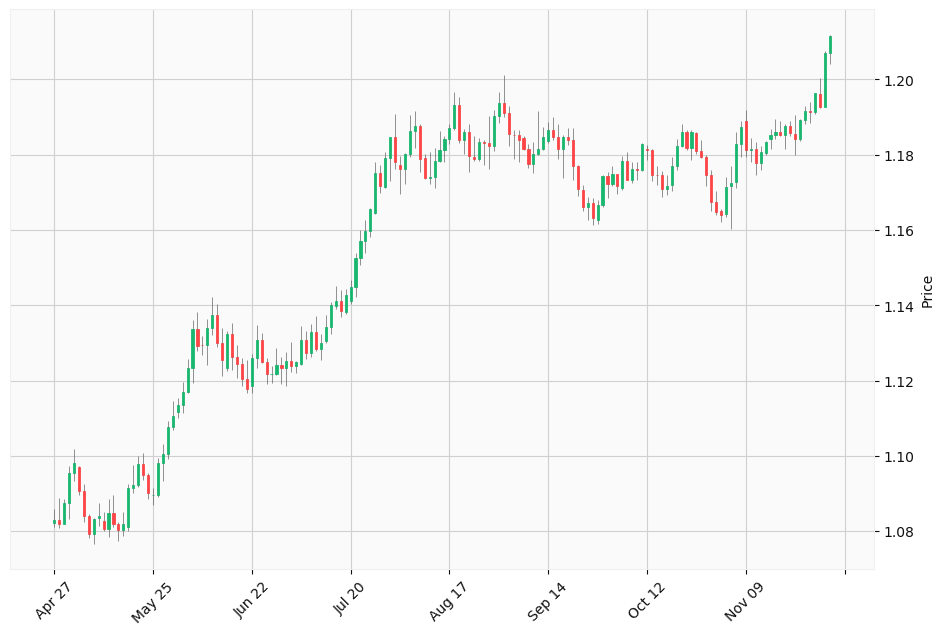

In [3]:
mpf.plot(df.iloc[:,1:],type = 'candle',style='yahoo',figsize=(12,8)) #sense check

In [4]:
df = df.reset_index(drop=True)

#### Method 1

Two higher highs and two lower lows

In [5]:
def checkresistance(df,i):
    resistance = df.loc[i,'High'] > df.loc[i-1,'High'] and \
                df.loc[i-1,'High'] > df.loc[i-2,'High'] and \
                df.loc[i+1,'High'] < df.loc[i,'High'] and \
                df.loc[i+2,'High'] < df.loc[i+1,'High']
    return resistance

levels = []
for i in range(2,df.shape[0]-2):
    if checkresistance(df,i):
        levels.append((str(df.loc[i,'Local time'].date()),round(df.loc[i,'High'],4),i))
        
levels

[('2020-05-01', 1.1019, 4),
 ('2020-05-21', 1.1008, 18),
 ('2020-06-10', 1.1423, 32),
 ('2020-06-23', 1.1349, 41),
 ('2020-08-06', 1.1916, 73),
 ('2020-08-18', 1.1966, 81),
 ('2020-09-01', 1.2011, 91),
 ('2020-09-15', 1.1901, 101),
 ('2020-09-21', 1.1872, 105),
 ('2020-10-06', 1.1808, 116),
 ('2020-10-21', 1.1881, 127),
 ('2020-11-09', 1.192, 140),
 ('2020-11-17', 1.1894, 146)]

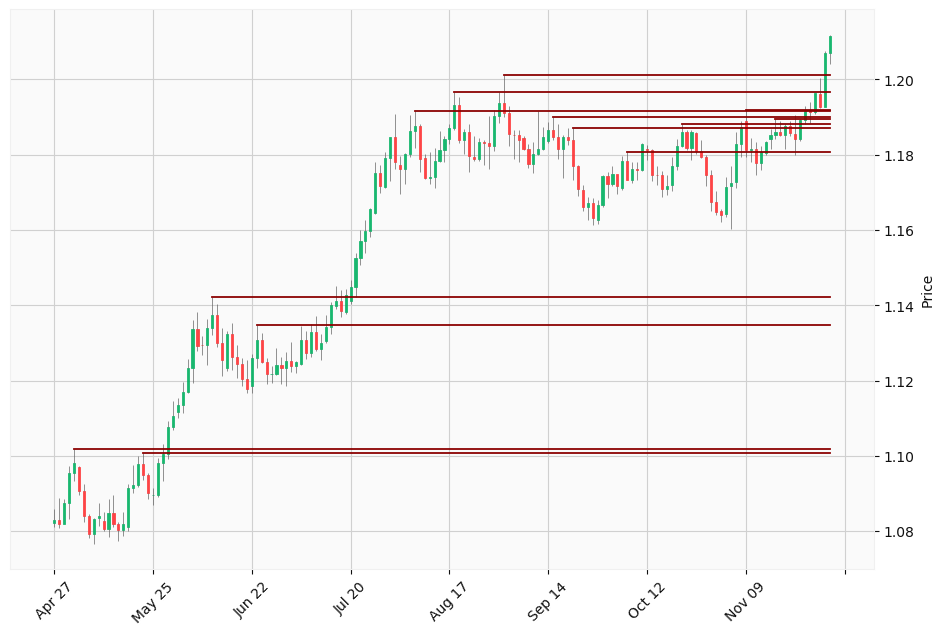

In [6]:
apdict = []
for level in levels:
    ls = [np.nan for i in range(level[2])] + [level[1] for i in range(level[2],len(df))]
    apdict.append(mpf.make_addplot(ls,color='darkred'))
df.index = pd.to_datetime(df['Local time'])
mpf.plot(df.iloc[:,1:],type = 'candle',style='yahoo',figsize=(12,8), addplot = apdict)

Combine similar levels, threshold based on average length of a candle

In [7]:
threshold = np.mean(df['High'] - df['Low'])

In [8]:
def farenough(x,levels):
    counter = 0
    for level in levels:
        if abs(x-level[1]) < threshold:
            counter += 1
    return counter

df = df.reset_index(drop=True)
levels = []
levels_counter = []
for i in range(2,df.shape[0]-2):
    if checkresistance(df,i):
        x = df.loc[i,'High']
        if farenough(x, levels) == 0:
            levels.append([str(df.loc[i,'Local time'].date()),round(df.loc[i,'High'],4),i])
        else:
            levels_counter.append([str(df.loc[i,'Local time'].date()),round(df.loc[i,'High'],4),i])
            
for level in levels:
    counter = 0
    for repeat_level in levels_counter:
        if abs(level[1]-repeat_level[1]) < threshold:
            counter += 1
    msg = 'Number of Rejections is :' + str(counter + 1)
    level.append(msg)
    
levels

[['2020-05-01', 1.1019, 4, 'Number of Rejections is :2'],
 ['2020-06-10', 1.1423, 32, 'Number of Rejections is :2'],
 ['2020-08-06', 1.1916, 73, 'Number of Rejections is :7'],
 ['2020-09-01', 1.2011, 91, 'Number of Rejections is :2'],
 ['2020-10-06', 1.1808, 116, 'Number of Rejections is :3']]

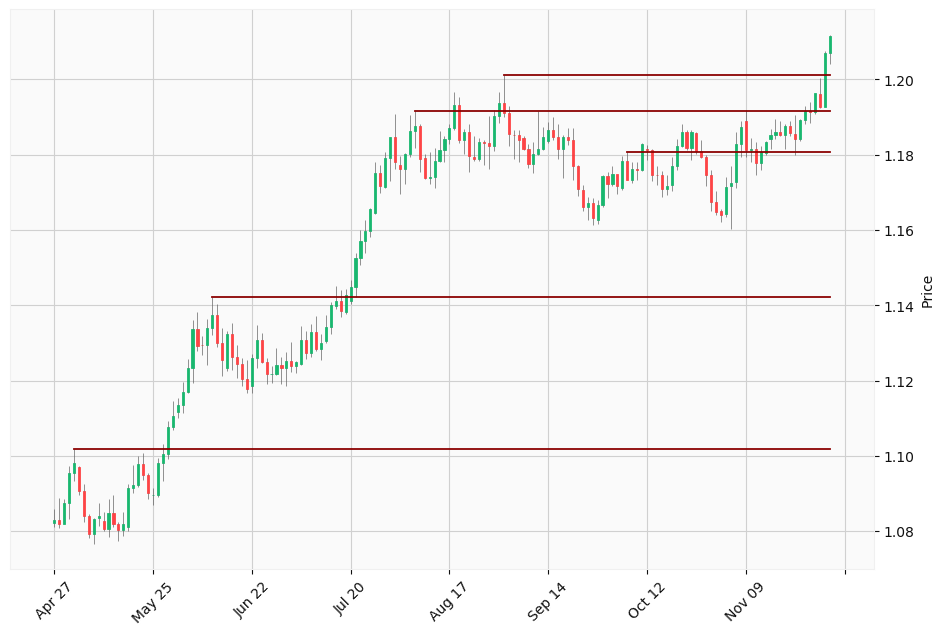

In [9]:
apdict = []
for level in levels:
    ls = [np.nan for i in range(level[2])] + [level[1] for i in range(level[2],len(df))]
    apdict.append(mpf.make_addplot(ls,color='darkred'))
df.index = pd.to_datetime(df['Local time'])
mpf.plot(df.iloc[:,1:],type = 'candle',style='yahoo',figsize=(12,8), addplot = apdict)

#### Method 2
max for 5 days straight

In [41]:
days = 5

df = df.reset_index(drop=True)

def resistancecheck(df):
    resistance_ls = []
    for i in range(4,len(df)-6):
        range_ls = (df.loc[i-4:i+6,'High']).to_list()
        date_range = (df.loc[i-4:i+6,'Local time']).to_list()
        current_max = df.loc[i,'High']
        index = range_ls.index(current_max)
        if current_max == max(range_ls) and index == 4:
            resistance_ls.append((str(date_range[index].date()),round(range_ls[index],4),i))
    return resistance_ls

In [42]:
result = resistancecheck(df) 
result #from method 2

[('2020-05-01', 1.1019, 4),
 ('2020-06-10', 1.1423, 32),
 ('2020-06-23', 1.1349, 41),
 ('2020-08-06', 1.1916, 73),
 ('2020-08-18', 1.1966, 81),
 ('2020-09-01', 1.2011, 91),
 ('2020-09-10', 1.1918, 98),
 ('2020-10-09', 1.1832, 119),
 ('2020-10-21', 1.1881, 127),
 ('2020-11-09', 1.192, 140)]

In [43]:
levels #from method 1 to compare

[['2020-05-01', 1.1019, 4, 'Number of Rejections is :2'],
 ['2020-06-10', 1.1423, 32, 'Number of Rejections is :2'],
 ['2020-08-06', 1.1916, 73, 'Number of Rejections is :7'],
 ['2020-09-01', 1.2011, 91, 'Number of Rejections is :2'],
 ['2020-10-06', 1.1808, 116, 'Number of Rejections is :3']]

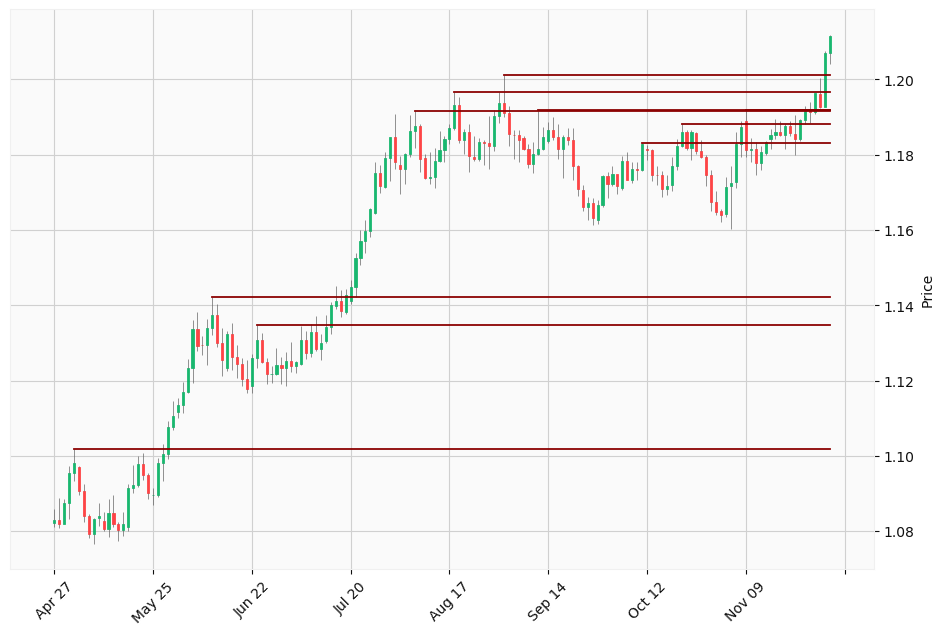

In [44]:
apdict = []
for r in result:
    ls = [np.nan for i in range(r[2])] + [r[1] for i in range(r[2],len(df))]
    apdict.append(mpf.make_addplot(ls,color='darkred'))
df.index = pd.to_datetime(df['Local time'])
mpf.plot(df.iloc[:,1:],type = 'candle',style='yahoo',figsize=(12,8), addplot = apdict)